# Tutorial: Using SMADI for Soil Moisture Anomaly Detection


### Introduction

In this tutorial, we will explore how to use the SMADI (Soil Moisture Anomaly Detection Indices) package for computing and plotting anomalies in soil moisture observations, particularly focusing on [ASCAT](https://hsaf.meteoam.it/Products/ProductsList?type=soil_moisture) surface soil moisture CDR time-series products.

This workflow can be applied to different meteorological variables and across various spatial scales. Whether you're analyzing a single grid data point by its grid ID or latitude and longitude coordinates, conducting country-level analysis based on country names, or defining a custom area of interest (AOI) using a bounding box defined by minimum and maximum latitude and longitude coordinates.


## Table of Contents

1. Installation
2. Loading the data
3. Computing the climatology
4. Detecting the Anomalies
5. Applying the workflow on a country scale or bbox


### 1. Installation

In this section we'll cover how to install SMADI package

1. Prerequisites
2. Installing SMADI
3. Verifying Installation

##### 1.1 Prerequisites

Before installing SMADI, ensure that you have Python installed on your system. SMADI is compatible with Python 3.x versions. It's recommended to create a virtual environment for installing the package to manage dependencies and ensure isolation from other Python installations.

##### 1.2 Installing SMADI

You can install SMADI using pip, which is the recommended method:


In [1]:
%%capture --no-display
! pip install smadi

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import warnings

warnings.filterwarnings("ignore")

%matplotlib inline

This command will download and install the latest version of SMADI along with its dependencies. Also, a full list of dependencies required to run this notebook is available in the file requiremets.txt at [SMADI](https://github.com/MuhammedM294/smadi) github repo.

##### 1.3 Verifying Installation

To verify that SMADI has been installed correctly, you can run the following command in your Python environment:


In [3]:
import smadi

print(smadi.__version__)

0.2.4


If SMADI has been installed successfully, this command will print the version number of the installed package.


### 2. Loading ASCAT Data

To load soil moisture data from a specific grid data point, you can use the `read_grid_point` function provided by SMADI. This function allows you to extract ASCAT soil moisture time series for a given location.

- If you already have the data downloaded in NetCDF format on your local machine


_Note: Cells in this notebook should be executed in order (from top to bottom). Some of the later examples depend on previous ones!_


In [4]:
from smadi.data_reader import read_grid_point

# set the path to ascat data
data_path = "/home/m294/VSA/Code/datasets"

# A grid point in Morocco
lon = -7.382
lat = 33.348

# Fibonaci grid (6.25). For more information see https://dgg.geo.tuwien.ac.at/
gpid = 3611180

# Define the location of the observation point
loc = (lon, lat)  # or loc = gpid

# Extract ASCAT soil moisture time series for the given location
data = read_grid_point(loc=loc, ascat_sm_path=data_path, read_bulk=False)

ascat_ts = data.get("ascat_ts")
ascat_ts.head()

ASCAT GPI: 3611180 - distance:   23.713 m


,sm,sm_noise,as_des_pass,ssf,sat_id,proc_flag,corr_flag,conf_flag,slope40,slope40_noise,curvature40,curvature40_noise,sigma40,sigma40_noise,num_sigma
2007-01-01 21:02:04.161,34.860001,3.24,0,0,3,0,0,0,-0.151653,0.001346,0.001486,0.000120,-12.270000,0.192,3
2007-01-02 11:03:22.807,23.160000,3.27,1,0,3,0,0,0,-0.151377,0.001349,0.001506,0.000120,-13.046000,0.193,3
2007-01-03 10:42:47.739,33.049999,3.23,1,0,3,0,0,0,-0.151143,0.001350,0.001527,0.000120,-12.389001,0.191,3
2007-01-03 22:00:39.007,25.599998,3.24,0,0,3,0,0,0,-0.151143,0.001350,0.001527,0.000120,-12.884001,0.191,3
2007-01-05 10:01:27.519,28.730000,3.24,1,0,3,0,0,0,-0.150600,0.001350,0.001547,0.000121,-12.670001,0.191,3


In the above code:

    - loc: Specifies the location of the observation point. You can define it either by latitude and longitude coordinates or by grid point ID.
    - ascat_sm_path: Specifies the path to the ASCAT soil moisture data.
    - read_bulk: Determines whether to read the entire ASCAT dataset into memory or read only the necessary data for the specified location.


In [5]:
# Filter the time series to get only the soil moisture data
sm_ts = ascat_ts.get("sm")
sm_ts.head()

2007-01-01 21:02:04.161    34.860001
2007-01-02 11:03:22.807    23.160000
2007-01-03 10:42:47.739    33.049999
2007-01-03 22:00:39.007    25.599998
2007-01-05 10:01:27.519    28.730000
Name: sm, dtype: float32

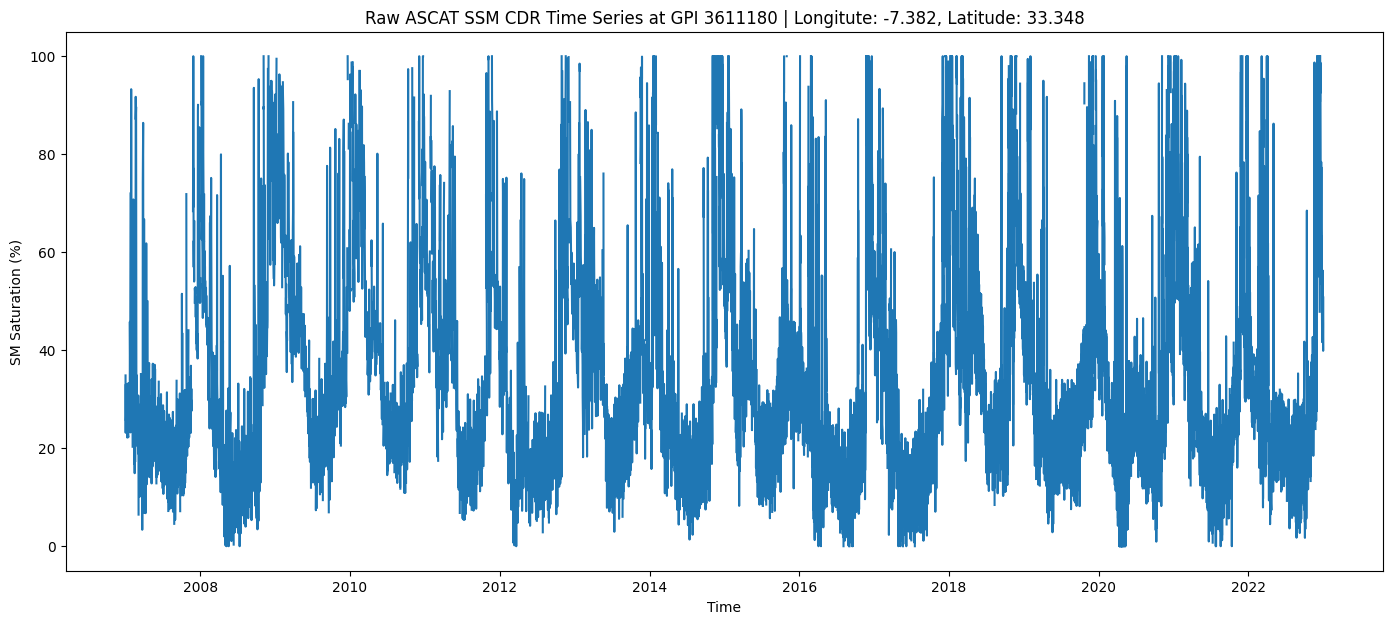

In [6]:
# Plot the time series
import matplotlib.pyplot as plt

plt.figure(figsize=(17, 7))
plt.plot(sm_ts.index, sm_ts.values)
plt.ylabel("SM Saturation (%)")
plt.xlabel("Time")
plt.title(
    f"Raw ASCAT SSM CDR Time Series at GPI {gpid} | Longitute: {lon}, Latitude: {lat}"
)
plt.show()

### 3. Computing the climatology

In this section, we'll explore how to compute climate normals (climatology) for the variable of interest using the `Climatology` class from the SMADI package. The class offers a range of functionalities to compute normals at various time steps, including monthly, bimonthly, dekadal, weekly, and daily intervals. Additionally, it provides flexibility in computing different metrics such as mean, median, minimum, and maximum values.


##### 3.1 Compute monthly mean normal (Basic example)


In [7]:
from smadi.climatology import Climatology

# Create a climatology object
cl = Climatology(df=ascat_ts, variable="sm")

# Set the time step for computing the climatology
cl.time_step = (
    "month"  # Supported time steps are "month", "bimonth", "dekad","week", "day"
)

cl_df = cl.compute_normals()
cl_df.head()

,sm-avg,norm-mean
2007-01-01,33.691360,56.541515
2007-02-01,38.154118,46.619137
2007-03-01,25.630455,36.692562
2007-04-02,24.852352,33.537384
2007-05-01,24.213409,28.730999


In the above code:

-     cl_df : the resulted data frame  containing the SM monthly normals and average for each month
-     sm_avg : the monthly average for each month computed from the average of the daily observations
-     norm-mean: the monthly normal for each month computed from the sm-avg over the 16 years on observations (2007-2022)


##### 3.2 Computing the normals using different metrics (median, max, ..etc)


In [8]:
# Change the metric of the normal to median and compute the climatology

# Set the metric for computing the climatology
cl.normal_metrics = ["median"]

cl_df = cl.compute_normals()
cl_df.head()

,sm-avg,norm-median
2007-01-01,33.691360,58.220169
2007-02-01,38.154118,45.390244
2007-03-01,25.630455,34.361500
2007-04-02,24.852352,31.528980
2007-05-01,24.213409,24.224533


In [9]:
# Compute normals with multiple metrics

# Set the metric for computing the climatology
cl.normal_metrics = ["mean", "median", "min", "max"]

cl_df = cl.compute_normals()
cl_df.head()

,sm-avg,norm-mean,norm-median,norm-min,norm-max
2007-01-01,33.691360,56.541515,58.220169,33.680332,79.198181
2007-02-01,38.154118,46.619137,45.390244,25.457748,78.506317
2007-03-01,25.630455,36.692562,34.361500,12.444318,56.690998
2007-04-02,24.852352,33.537384,31.528980,14.702118,49.177536
2007-05-01,24.213409,28.730999,24.224533,10.002137,54.855000


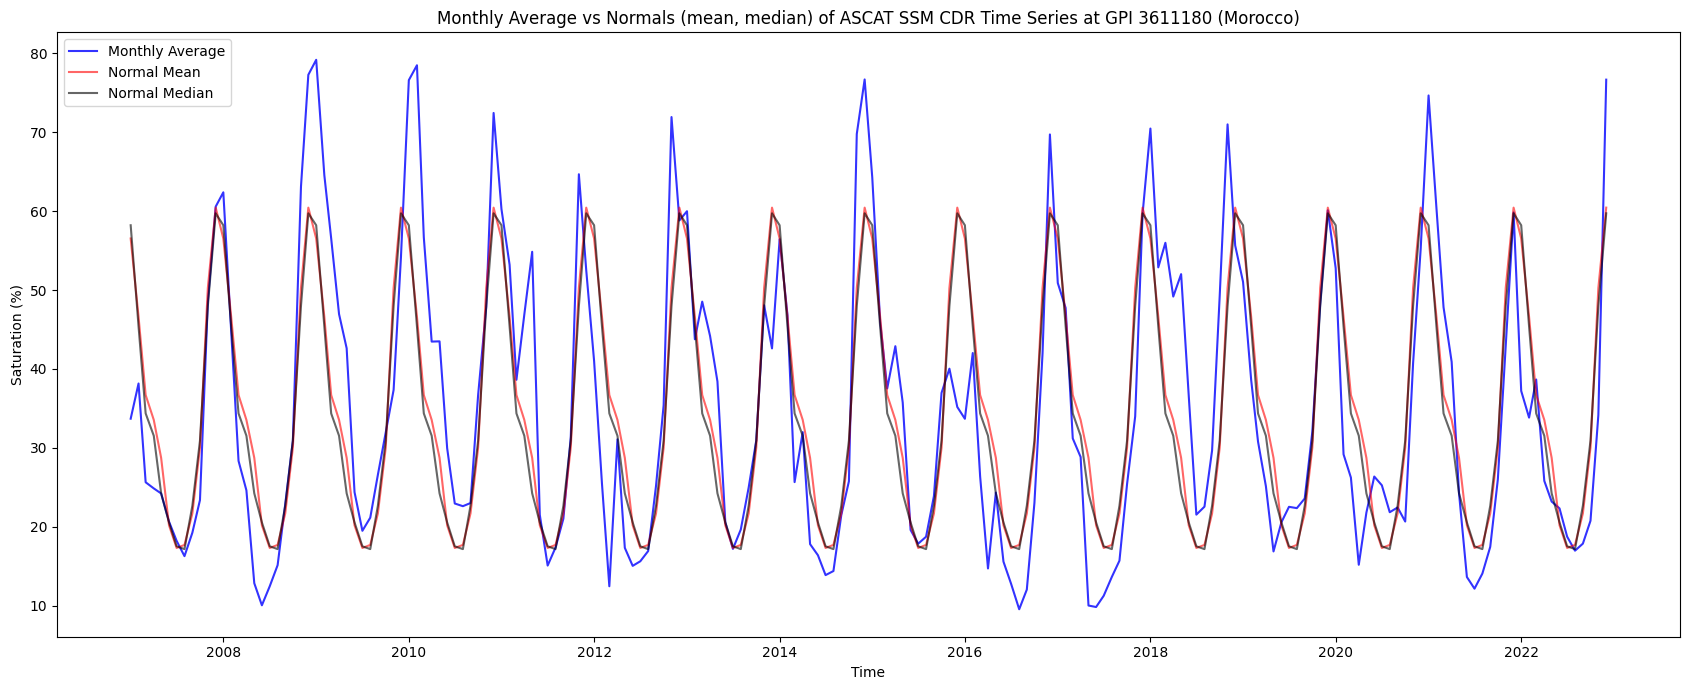

In [10]:
from smadi.plot import plot_ts

colms = {
    "sm-avg": {
        "color": "blue",
        "label": "Monthly Average",
        "alpha": 0.8,
        "linewidth": 1.5,
    },
    "norm-mean": {"color": "red", "label": "Normal Mean", "alpha": 0.6},
    "norm-median": {"color": "black", "label": "Normal Median", "alpha": 0.6},
}


plot_ts(
    df=cl_df,
    x_axis=cl_df.index,
    colmns_kwargs=colms,
    figsize=(17, 7),
    legend=True,
    grid=False,
    xlabel="Time",
    ylabel="Saturation (%)",
    title=f"Monthly Average vs Normals (mean, median) of ASCAT SSM CDR Time Series at GPI {gpid} (Morocco)",
)

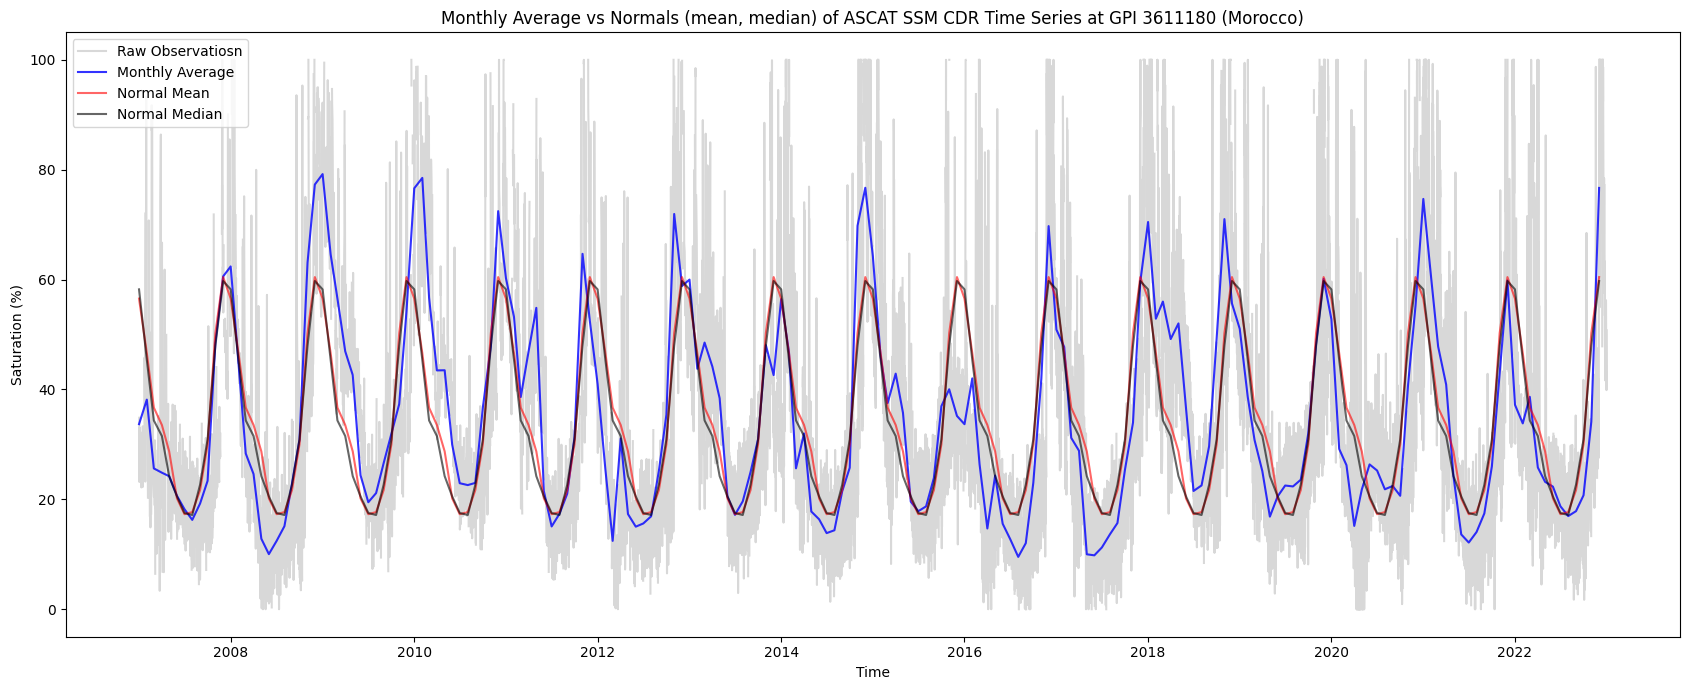

In [11]:
plot_ts(
    df=cl_df,
    x_axis=cl_df.index,
    colmns_kwargs=colms,
    plot_raw=True,
    clim_obj=cl,
    raw_var="sm",
    raw_kwargs={"color": "grey", "label": "Raw Observatiosn", "alpha": 0.3},
    figsize=(17, 7),
    legend=True,
    grid=False,
    xlabel="Time",
    ylabel="Saturation (%)",
    title=f"Monthly Average vs Normals (mean, median) of ASCAT SSM CDR Time Series at GPI {gpid} (Morocco)",
)

#### 3.3 Computing the normals for a subset of the data

To work on a subset of the data instead of the entire historical record, users can specify the timespan, a class attribute of the Climatology class. By providing the timespan parameter, users can restrict the computation to a specific time period of interest, allowing for focused analysis within a defined timeframe.


In [12]:
# set start and end date for the climatology by providing 'timespan' parameter

cl.timespan = ("2010-01-01", "2019-12-31")  # ('start_date', 'end_date')
cl.time_step = "week"
cl.normal_metrics = ["mean", "median", "min", "max"]

cl_df = cl.compute_normals()
cl_df

,sm-avg,norm-mean,norm-median,norm-min,norm-max
2010-01-01,75.634995,47.240093,33.206665,32.878613,75.634995
2010-01-04,85.112991,52.262764,49.025082,39.880833,85.112991
2010-01-11,80.447502,50.063923,44.561417,26.406000,93.014717
2010-01-18,61.383751,56.987892,58.483208,27.776667,76.887917
2010-01-26,75.996246,63.828270,66.942291,26.440832,85.871330
...,...,...,...,...,...
2019-11-25,36.130405,65.901901,67.807747,36.130405,95.517502
2019-12-02,77.321304,59.382526,59.508751,34.807999,88.868332
2019-12-09,42.437664,56.611816,56.610832,34.222664,83.028748
2019-12-16,75.181274,62.063293,56.780205,35.804165,91.145561


#### 3.4 Optianal Functionalities


In [13]:
# Apply filling the gaps and smoothing the time series

cl.fillna = True
cl.fillna_window_size = 3  # number of days to fill the gaps by their mean value
cl.smoothing = True
cl.smooth_window_size = 31  # The moving average window size

cl.time_step = "dekad"
cl.normal_metrics = ["mean", "median"]
cl_df = cl.compute_normals()

cl_df

,sm-avg,dekad,norm-mean,norm-median
2010-01-01,76.893457,1,56.205517,53.735990
2010-01-11,76.060781,2,56.157869,55.372519
2010-01-21,75.829913,3,55.430151,57.809547
2010-02-01,76.124038,1,52.268098,53.774116
2010-02-11,76.071177,2,47.683856,47.396843
...,...,...,...,...
2019-11-11,50.193662,2,53.198076,50.481307
2019-11-21,55.019200,3,57.973472,58.609284
2019-12-01,58.024901,1,59.332765,61.821026
2019-12-11,58.485274,2,58.131401,59.094905


In [14]:
# filter the result to get a specific date range by passing data parameters year, month, day, ..etc to the compute_normals method
# For bimonth and dekad parameters, only eligible to use when the time_step is set to 'bimonth' or 'dekad'
cl_df = cl.compute_normals(year=2015, month=5)
cl_df

,sm-avg,dekad,norm-mean,norm-median
2015-05-01,38.968720,1,32.848370,30.646656
2015-05-11,35.044007,2,30.419932,28.604511
2015-05-21,30.225323,3,27.176937,25.249230


For date parameters:

-       _Dekad: values are from 1 to 3 for each month, corresponding to the first, second, and third dekads of the month_
-       _bimonth: bimonth values are 1, 2 for each month, corresponding to the first and second half of the month


In [15]:
cl.time_step = "bimonth"
cl_df = cl.compute_normals(month=5, bimonth=2)
cl_df

,sm-avg,bimonth,norm-mean,norm-median
2010-05-16,39.808132,2,27.975584,26.078721
2011-05-16,45.039238,2,27.975584,26.078721
2012-05-16,16.257197,2,27.975584,26.078721
2013-05-16,33.199088,2,27.975584,26.078721
2014-05-16,16.965769,2,27.975584,26.078721
2015-05-16,31.389993,2,27.975584,26.078721
2016-05-16,20.767449,2,27.975584,26.078721
2017-05-16,10.459389,2,27.975584,26.078721
2018-05-16,48.011478,2,27.975584,26.078721
2019-05-16,17.858104,2,27.975584,26.078721


### 4. Detecting the Anomalies


In [16]:
from smadi.anomaly_detectors import (
    ZScore,
    SMAPI,
    SMDI,
    SMCA,
    SMAD,
    SMCI,
    SMDS,
    ESSMI,
    ParaDis,
    AbsoluteAnomaly,
)

#### 4.1 Zscore Usage Example


In [17]:
zscore = ZScore(
    df=ascat_ts,
    variable="sm",
    fillna=True,
    fillna_window_size=3,
    smoothing=True,
    smooth_window_size=31,
    time_step="month",
)

anomaly_df = zscore.detect_anomaly()
anomaly_df

,sm-avg,norm-mean,zscore
2007-01-01,33.471936,55.734672,-1.687298
2007-02-01,35.623916,47.037372,-0.889188
2007-03-01,28.020249,37.128002,-0.809405
2007-04-01,27.934501,33.375276,-0.511452
2007-05-01,24.592070,28.083468,-0.294929
...,...,...,...
2022-08-01,16.960596,18.244689,-0.343926
2022-09-01,17.975225,21.880373,-0.999917
2022-10-01,23.155093,31.723001,-1.196212
2022-11-01,41.366666,49.871156,-0.791415


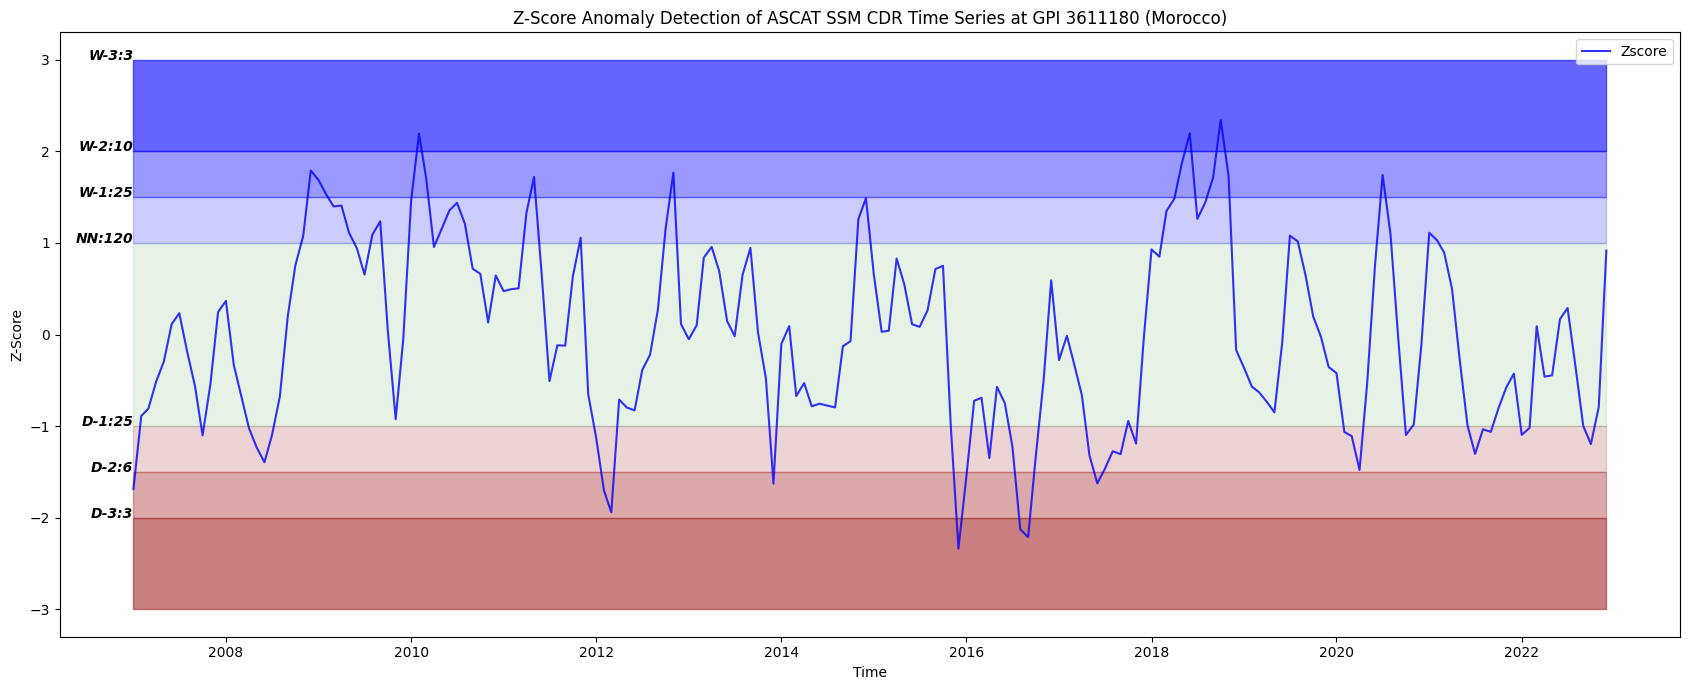

In [19]:
from smadi.plot import plot_anomaly

colm = {"zscore": {"color": "blue", "label": "Zscore", "alpha": 0.8, "linewidth": 1.5}}

plot_anomaly(
    df=anomaly_df,
    x_axis=anomaly_df.index,
    colmns=colm,
    thresholds="zscore",
    plot_hbars=True,
    plot_categories=True,
    figsize=(17, 7),
    grid=False,
    legend=True,
    xlabel="Time",
    ylabel="Z-Score",
    title=f"Z-Score Anomaly Detection of ASCAT SSM CDR Time Series at GPI {gpid} (Morocco)",
)

#### 4.2 SMAPI Usage Example

In [20]:
smapi = SMAPI(
    df=ascat_ts,
    variable="sm",
    fillna=True,
    fillna_window_size=3,
    smoothing=True,
    smooth_window_size=31,
    time_step="month",
    normal_metrics=["mean", "median"],
)

anomaly_df = smapi.detect_anomaly()
anomaly_df['smapi-mean'] = anomaly_df['smapi-mean'].clip(upper=100 , lower=-100)
anomaly_df['smapi-median'] = anomaly_df['smapi-median'].clip(upper=100 , lower=-100)
anomaly_df

,sm-avg,norm-mean,norm-median,smapi-mean,smapi-median
2007-01-01,33.471936,55.734672,54.718203,-39.944141,-38.828518
2007-02-01,35.623916,47.037372,47.141779,-24.264655,-24.432390
2007-03-01,28.020249,37.128002,35.583853,-24.530685,-21.255718
2007-04-01,27.934501,33.375276,28.206659,-16.301811,-0.964869
2007-05-01,24.592070,28.083468,23.700351,-12.432220,3.762471
...,...,...,...,...,...
2022-08-01,16.960596,18.244689,17.678374,-7.038170,-4.060199
2022-09-01,17.975225,21.880373,22.160417,-17.847722,-18.885891
2022-10-01,23.155093,31.723001,31.953248,-27.008505,-27.534462
2022-11-01,41.366666,49.871156,44.613189,-17.052923,-7.277047


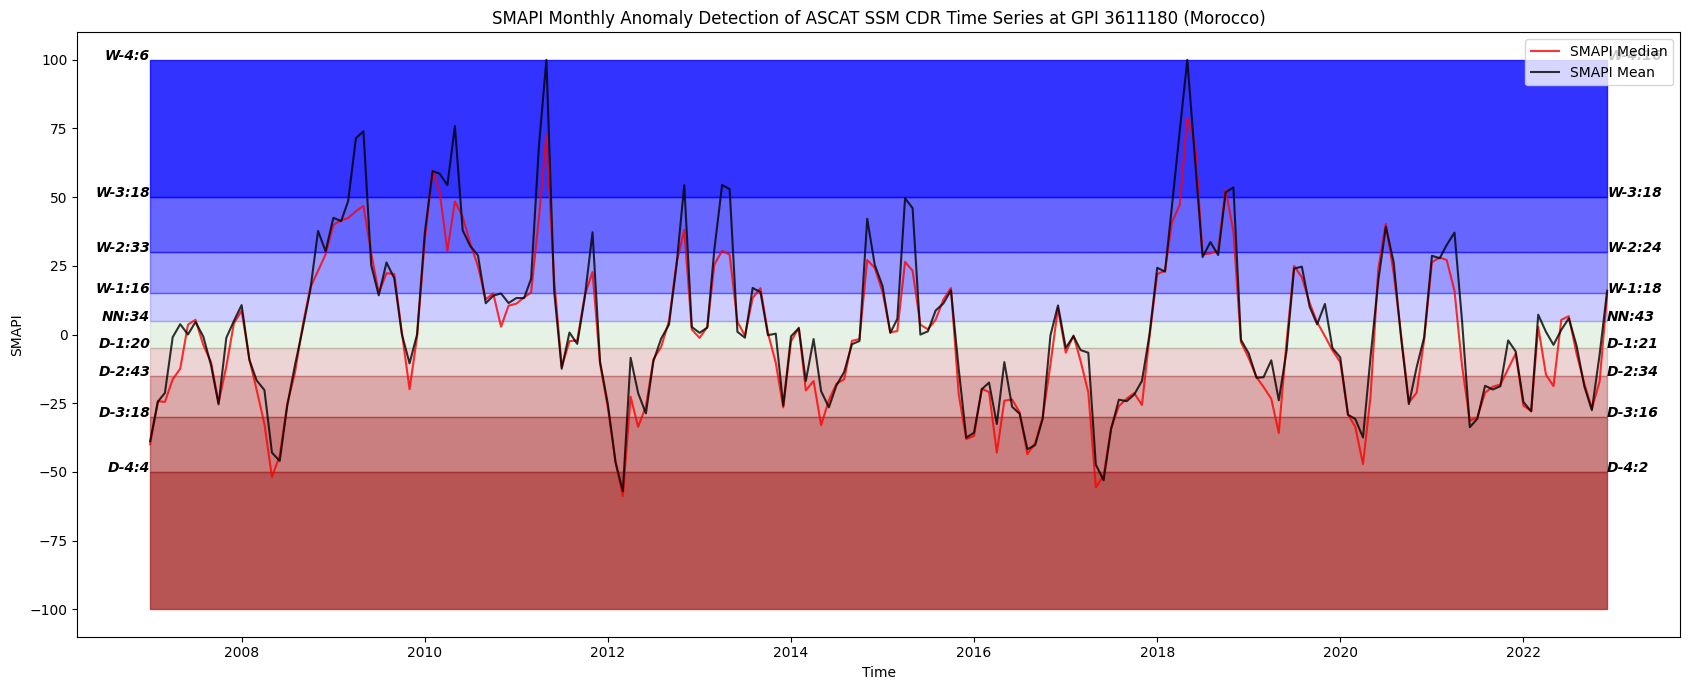

In [21]:
colms = {
    "smapi-mean": {
        "color": "red",
        "label": "SMAPI Median",
        "alpha": 0.8,
        "linewidth": 1.5,
    },
    "smapi-median": {
        "color": "black",
        "label": "SMAPI Mean",
        "alpha": 0.8,
        "linewidth": 1.5,
    },
    
}

plot_anomaly(
    df=anomaly_df,
    x_axis=anomaly_df.index,
    colmns=colms,
    thresholds="smapi",
    plot_hbars=True,
    plot_categories=True,
    figsize=(17, 7),
    grid=False,
    legend=True,
    xlabel="Time",
    ylabel="SMAPI",
    title=f"SMAPI Monthly Anomaly Detection of ASCAT SSM CDR Time Series at GPI {gpid} (Morocco)",
)

#### 4.3 ParaDis Usage Example

In [22]:
paradis = ParaDis(
    df=ascat_ts,
    variable="sm",
    fillna=True,
    fillna_window_size=3,
    smoothing=True,
    smooth_window_size=31,
    time_step="month",
    dist = ['beta','gamma'] 
)

anomaly_df = paradis.detect_anomaly()

# colm beta and gamma. for any value less than -4 set it to -4  and for any value greater than 4 set it to 4
anomaly_df['beta'] = anomaly_df['beta'].clip(lower=-3, upper=3)
anomaly_df['gamma'] = anomaly_df['gamma'].clip(lower=-3, upper=3)
anomaly_df

,sm-avg,norm-mean,beta,gamma
2007-01-01,33.471936,55.734672,-3.000000,-1.702506
2007-02-01,35.623916,47.037372,-0.619638,-0.867219
2007-03-01,28.020249,37.128002,-0.395972,-0.803120
2007-04-01,27.934501,33.375276,-0.198028,-0.402290
2007-05-01,24.592070,28.083468,-0.204429,0.226291
...,...,...,...,...
2022-08-01,16.960596,18.244689,-0.460257,-0.320492
2022-09-01,17.975225,21.880373,-0.183913,-0.986603
2022-10-01,23.155093,31.723001,-0.255801,-0.171316
2022-11-01,41.366666,49.871156,-0.235870,-0.461163


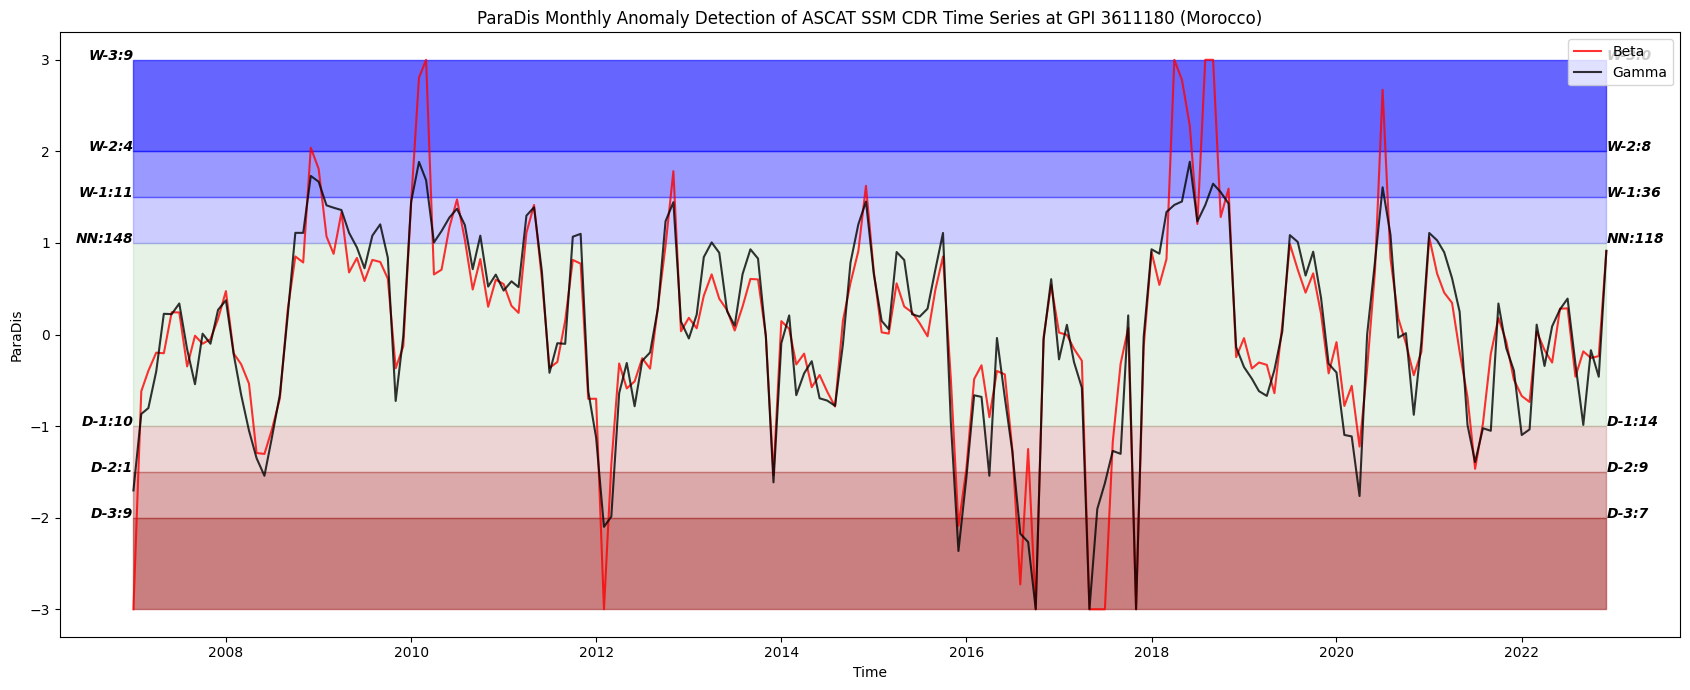

In [23]:
colms = {"beta": {"color": "red", "label": "Beta", "alpha": 0.8, "linewidth": 1.5},
        "gamma": {"color": "black", "label": "Gamma", "alpha": 0.8, "linewidth": 1.5}}


plot_anomaly(
    df=anomaly_df,
    x_axis=anomaly_df.index,
    colmns=colms,
    thresholds="zscore",
    plot_hbars=True,
    plot_categories=True,
    figsize=(17, 7),
    grid=False,
    legend=True,
    xlabel="Time",
    ylabel="ParaDis",
    title=f"ParaDis Monthly Anomaly Detection of ASCAT SSM CDR Time Series at GPI {gpid} (Morocco)",
)

### 5. Applying Workflow on a country scale or bbox

In [24]:
! run  -h

usage: run [-h] [--data_read_bulk DATA_READ_BULK] [--variable variable] --year
           [year ...] [--month [month ...]] [--dekad [dekad ...]]
           [--week [week ...]] [--bimonth [bimonth ...]] [--day [day ...]]
           [--methods [methods ...]] [--timespan timespan] [--fillna FILLNA]
           [--fillna_size FILLNA_SIZE] [--smoothing SMOOTHING]
           [--smooth_size SMOOTH_SIZE] [--workers workers] [--save_to SAVE_TO]
           data_path aoi time_step

Run the SMADI workflow for anomaly detection in ASCAT data

positional arguments:
  data_path             Path to the ASCAT data
  aoi                   Country name or bounding box coordinates in the tuple
                        'lon_min, lon_max , lat_min, lat_max'
  time_step             The time step for the climatology calculation.
                        Supported values: month, dekad, week, bimonth, day

options:
  -h, --help            show this help message and exit
  --data_read_bulk DATA_READ_BULK
          

In [25]:
# Compute four anomaly maps for Germany using the ZScore and SMAD methods for June and July 2021
! run "/home/m294/VSA/Code/datasets" "Germany" 'month' --variable "sm" --year 2021 2021 --month 6 7  --methods 'zscore' 'smad' --fillna True --fillna_size 3 --save_to "output_df.csv"



Workflow started....

Loading grid points for Germany....
Grid points loaded successfully for Germany

     point  cell                 grid        lat        lon
0  4838920  1395  Fibonacci (6.25 km)  47.344479  10.382991
1  4841504  1395  Fibonacci (6.25 km)  47.377457  10.320685
2  4843101  1395  Fibonacci (6.25 km)  47.397850  10.421497
3  4844088  1395  Fibonacci (6.25 km)  47.410458  10.258380
4  4845685  1395  Fibonacci (6.25 km)  47.430862  10.359192


Running the anomaly detection workflow for Germany....

Workflow parameters:

    Anomaly detection methods: zscore, smad
    Variable: sm
    Time step for Climatology: month
    Date parameters:

     Year: [2021, 2021]
     Month: [6, 7]

Workflow completed in 315.6401948928833 seconds

        point  cell  ... smad(2021-6)  smad(2021-7)
0     4838920  1395  ...    -0.944715      1.252402
1     4841504  1395  ...    -0.477110      1.159104
2     4843101  1395  ...    -0.625209      1.041969
3     4844088  1395  ...    -0.1865

In [26]:
workflow_df = pd.read_csv("output_df.csv")
workflow_df.head()

,Unnamed: 0,point,cell,grid,lat,lon,zscore(2021-6),zscore(2021-7),smad(2021-6),smad(2021-7)
0,0,4838920,1395,Fibonacci (6.25 km),47.344479,10.382991,-0.876612,1.352159,-0.944715,1.252402
1,1,4841504,1395,Fibonacci (6.25 km),47.377457,10.320685,-0.549212,1.611515,-0.477110,1.159104
2,2,4843101,1395,Fibonacci (6.25 km),47.397850,10.421497,-0.721812,1.469408,-0.625209,1.041969
3,3,4844088,1395,Fibonacci (6.25 km),47.410458,10.258380,-0.428590,1.438613,-0.186536,0.941893
4,4,4845685,1395,Fibonacci (6.25 km),47.430862,10.359192,-0.527157,1.375189,-0.186146,1.005243


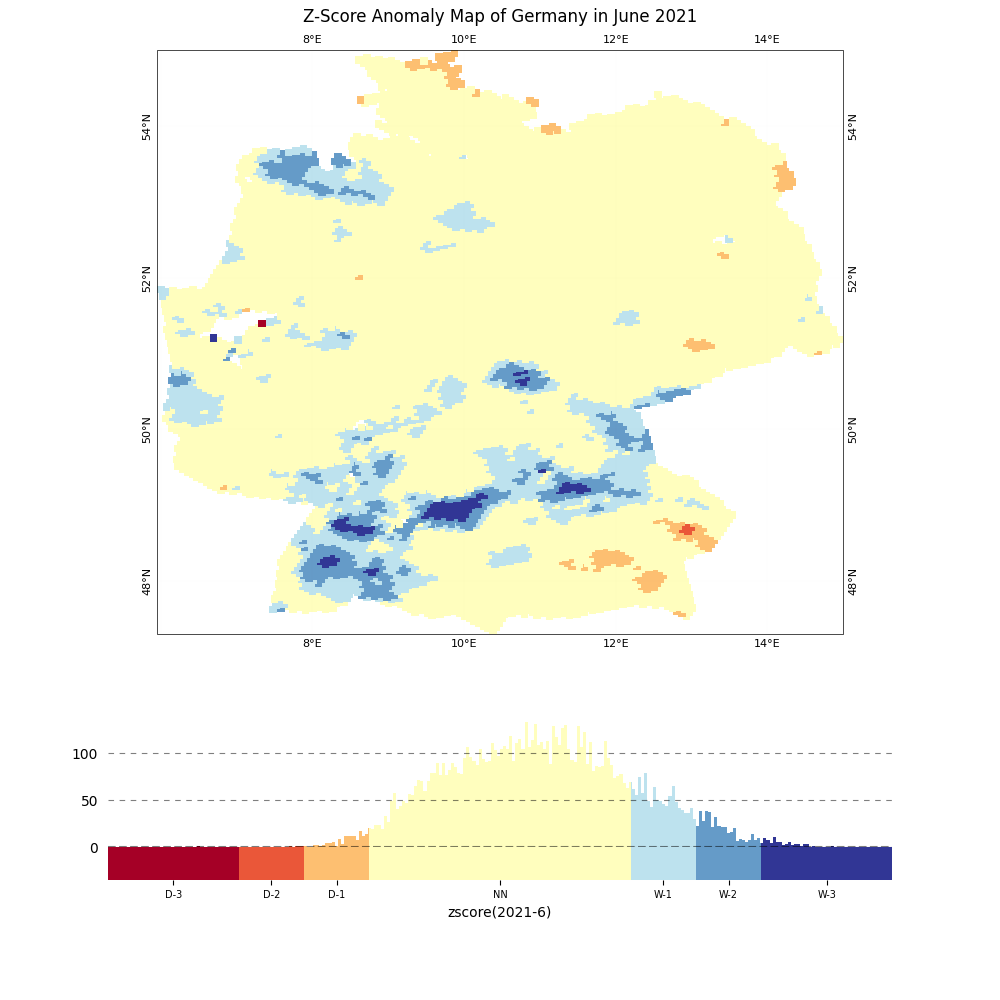

In [42]:
from smadi.map import plot_anomaly_map
plot_anomaly_map(df=workflow_df, 
                 colm='zscore(2021-6)',
                 x = 'lon',
                 y = 'lat',
                 title='Z-Score Anomaly Map of Germany in June 2021', figsize=(10, 10))

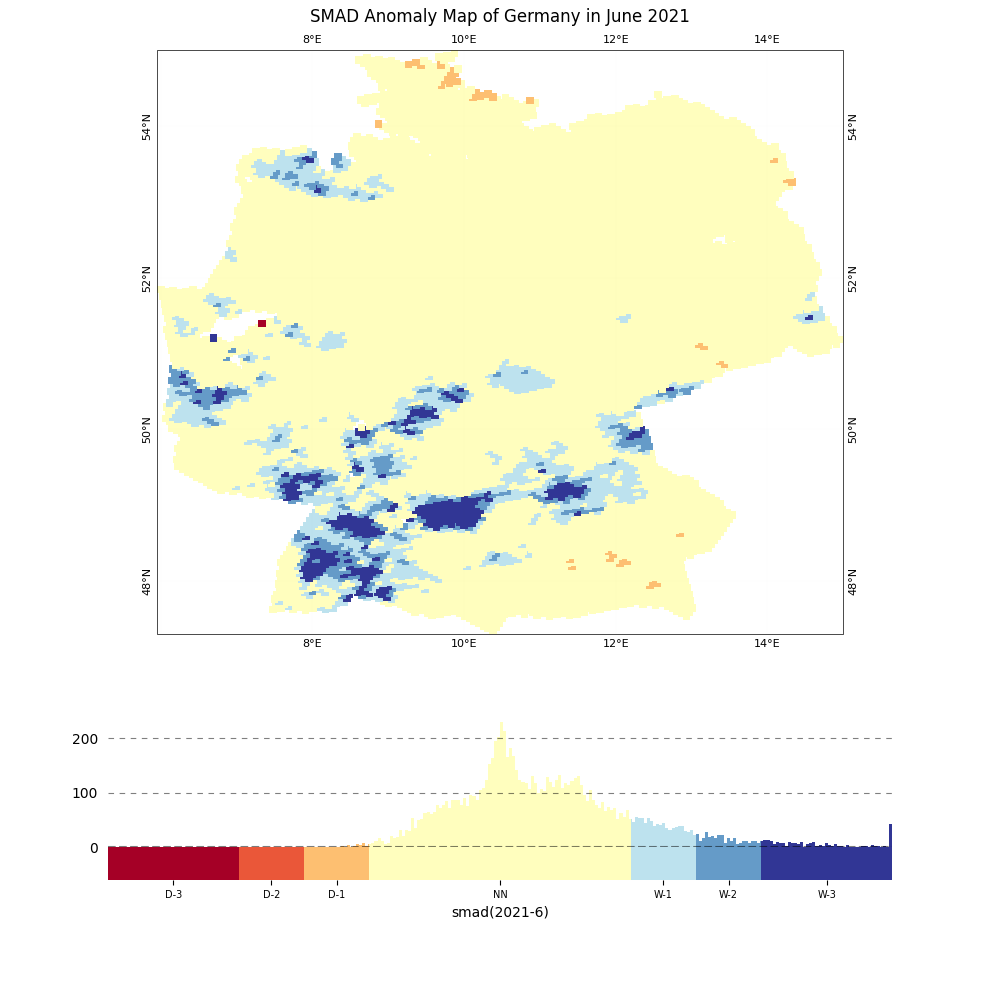

In [41]:
plot_anomaly_map(df=workflow_df, 
                 colm='smad(2021-6)',
                 x = 'lon',
                 y = 'lat',
                 title='SMAD Anomaly Map of Germany in June 2021', figsize=(10, 10))

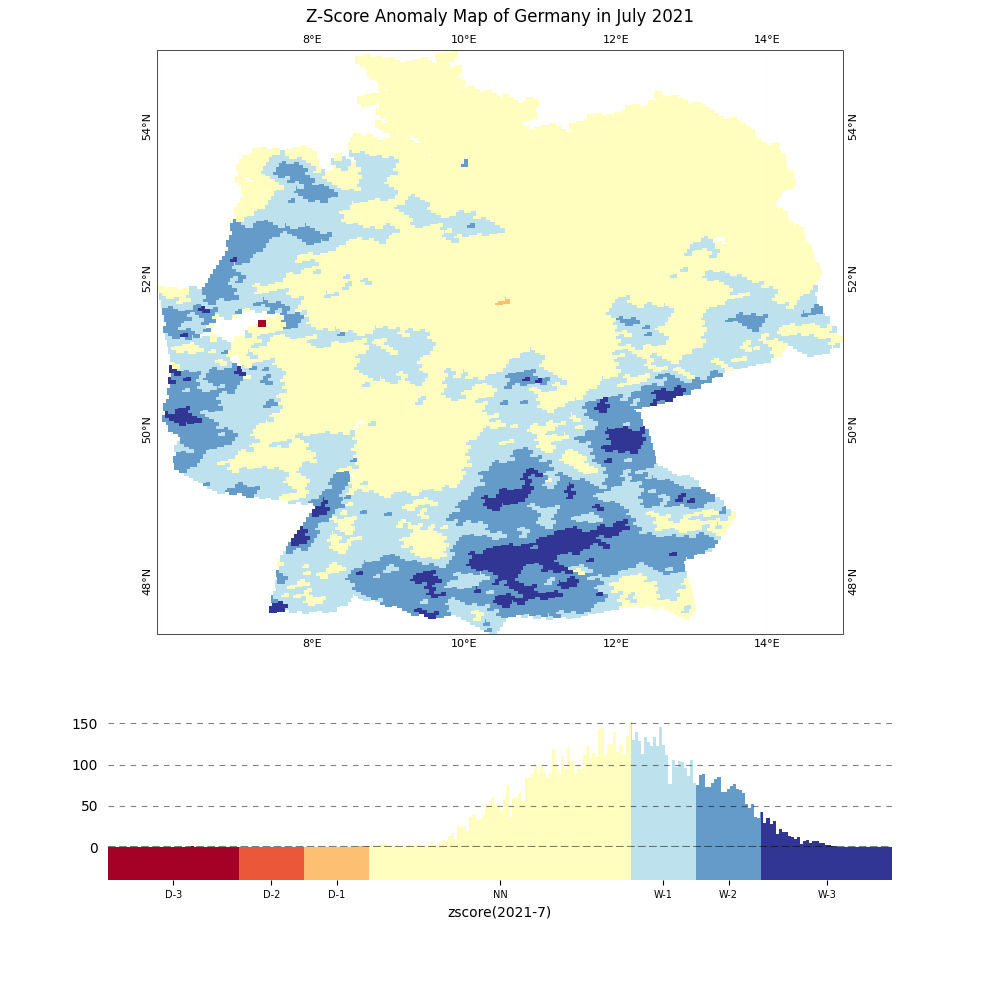

In [39]:
plot_anomaly_map(df=workflow_df, 
                 colm='zscore(2021-7)',
                 x = 'lon',
                 y = 'lat',
                 title='Z-Score Anomaly Map of Germany in July 2021', figsize=(10, 10))

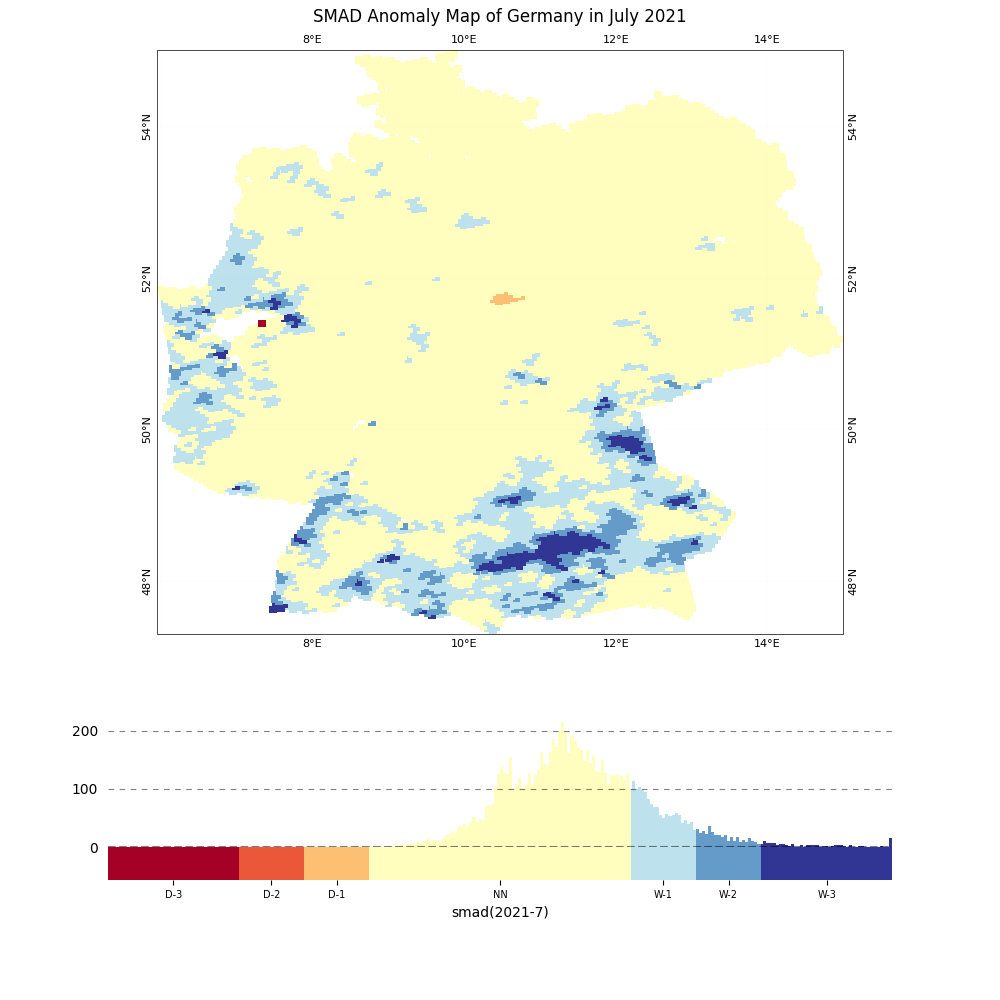

In [40]:
plot_anomaly_map(df=workflow_df, 
                 colm='smad(2021-7)',
                 x = 'lon',
                 y = 'lat',
                 title='SMAD Anomaly Map of Germany in July 2021', figsize=(10, 10))